In [23]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from tensorflow.keras import regularizers

In [25]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [26]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [27]:
tf.keras.backend.clear_session()

In [28]:
subject = 'Mato Grosso - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 0
train_split = split_index + 1 - 12

In [29]:
data = pd.read_csv('2003_mo_model_input_MT.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Mato Grosso - Produção de Cimento (t),Mato Grosso- custo m2 (R$),Mato Grosso - IDH Longevidade,Mato Grosso - Depósito Poupança (R$),Mato Grosso - Consumo de Cimento (t),Mato Grosso - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - IDH Renda,Mato Grosso - IDH,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - PIB - Preços de Mercado,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,50.917240,10522.560000,0.774167,1.402870e+06,47.470,0.713365,1.937098,994.641929,1307.693017,26.497759,22.112509,78.548056,2.038260,8.297178,0.756038,0.745147,6.084564e+07,2.670588e+06,16.831332,5.118946e+07,0.331800,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,50.851586,10614.965000,0.774487,1.418219e+06,45.387,0.713721,2.057965,994.309470,1283.219898,26.168996,21.331689,76.901685,1.862279,8.291317,0.755860,0.745308,6.092768e+07,2.672688e+06,16.835967,5.121614e+07,0.333615,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,50.970549,10702.843148,0.774808,1.433568e+06,44.907,0.714077,1.715492,994.660654,1261.062010,25.844852,20.557682,75.407092,1.802031,8.285457,0.755682,0.745469,6.100973e+07,2.674788e+06,16.840602,5.124282e+07,0.334864,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,51.049978,10785.405648,0.775128,1.448917e+06,45.467,0.714434,1.525801,995.244084,1235.995684,25.435732,19.399042,72.894611,1.794850,8.279596,0.755503,0.745630,6.109177e+07,2.676888e+06,16.845237,5.126950e+07,0.336048,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,51.567529,10863.369096,0.775449,1.464267e+06,56.246,0.714790,1.166060,995.697467,1233.790572,25.082755,17.830386,68.635209,1.820612,8.273735,0.755325,0.745791,6.117381e+07,2.678988e+06,16.849872,5.129619e+07,0.336447,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,37351.487561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,37305.538501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,37240.697573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,37158.452637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


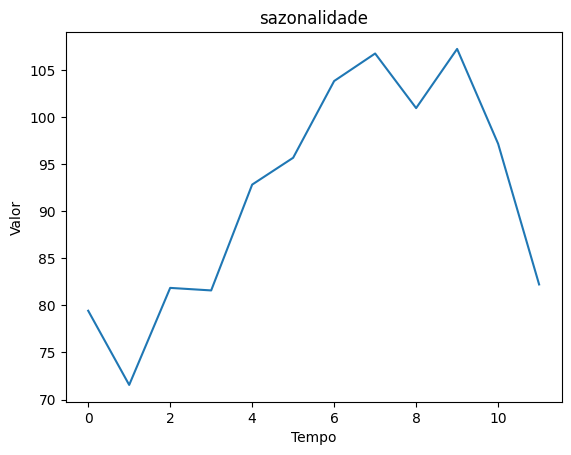

,sazonalidade
sazonalidade,
0,79.429412
1,71.551986
2,81.856015
3,81.586671
4,92.824887
5,95.675912
6,103.824181
7,106.747314
8,100.948211


In [30]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [31]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Mato Grosso - Produção de Cimento (t),Mato Grosso- custo m2 (R$),Mato Grosso - IDH Longevidade,Mato Grosso - Depósito Poupança (R$),Mato Grosso - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - IDH Renda,Mato Grosso - IDH,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - PIB - Preços de Mercado,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Mato Grosso - Consumo de Cimento (t)
0,2003-1,50.917240,10522.560000,0.774167,1.402870e+06,0.713365,1.937098,994.641929,1307.693017,26.497759,22.112509,78.548056,2.038260,8.297178,0.756038,0.745147,6.084564e+07,2.670588e+06,16.831332,5.118946e+07,0.331800,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,79.429412,47.470
1,2003-2,50.851586,10614.965000,0.774487,1.418219e+06,0.713721,2.057965,994.309470,1283.219898,26.168996,21.331689,76.901685,1.862279,8.291317,0.755860,0.745308,6.092768e+07,2.672688e+06,16.835967,5.121614e+07,0.333615,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,71.551986,45.387
2,2003-3,50.970549,10702.843148,0.774808,1.433568e+06,0.714077,1.715492,994.660654,1261.062010,25.844852,20.557682,75.407092,1.802031,8.285457,0.755682,0.745469,6.100973e+07,2.674788e+06,16.840602,5.124282e+07,0.334864,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,81.856015,44.907
3,2003-4,51.049978,10785.405648,0.775128,1.448917e+06,0.714434,1.525801,995.244084,1235.995684,25.435732,19.399042,72.894611,1.794850,8.279596,0.755503,0.745630,6.109177e+07,2.676888e+06,16.845237,5.126950e+07,0.336048,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,81.586671,45.467
4,2003-5,51.567529,10863.369096,0.775449,1.464267e+06,0.714790,1.166060,995.697467,1233.790572,25.082755,17.830386,68.635209,1.820612,8.273735,0.755325,0.745791,6.117381e+07,2.678988e+06,16.849872,5.129619e+07,0.336447,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,92.824887,56.246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,37351.487561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.824887,NaN
245,2023-6,NaN,37305.538501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.675912,NaN
246,2023-7,NaN,37240.697573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.824181,NaN
247,2023-8,NaN,37158.452637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.747314,NaN


In [32]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      55.998
1      49.346
2      57.277
3      61.881
4      65.040
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Mato Grosso - Consumo de Cimento (t), Length: 249, dtype: float64

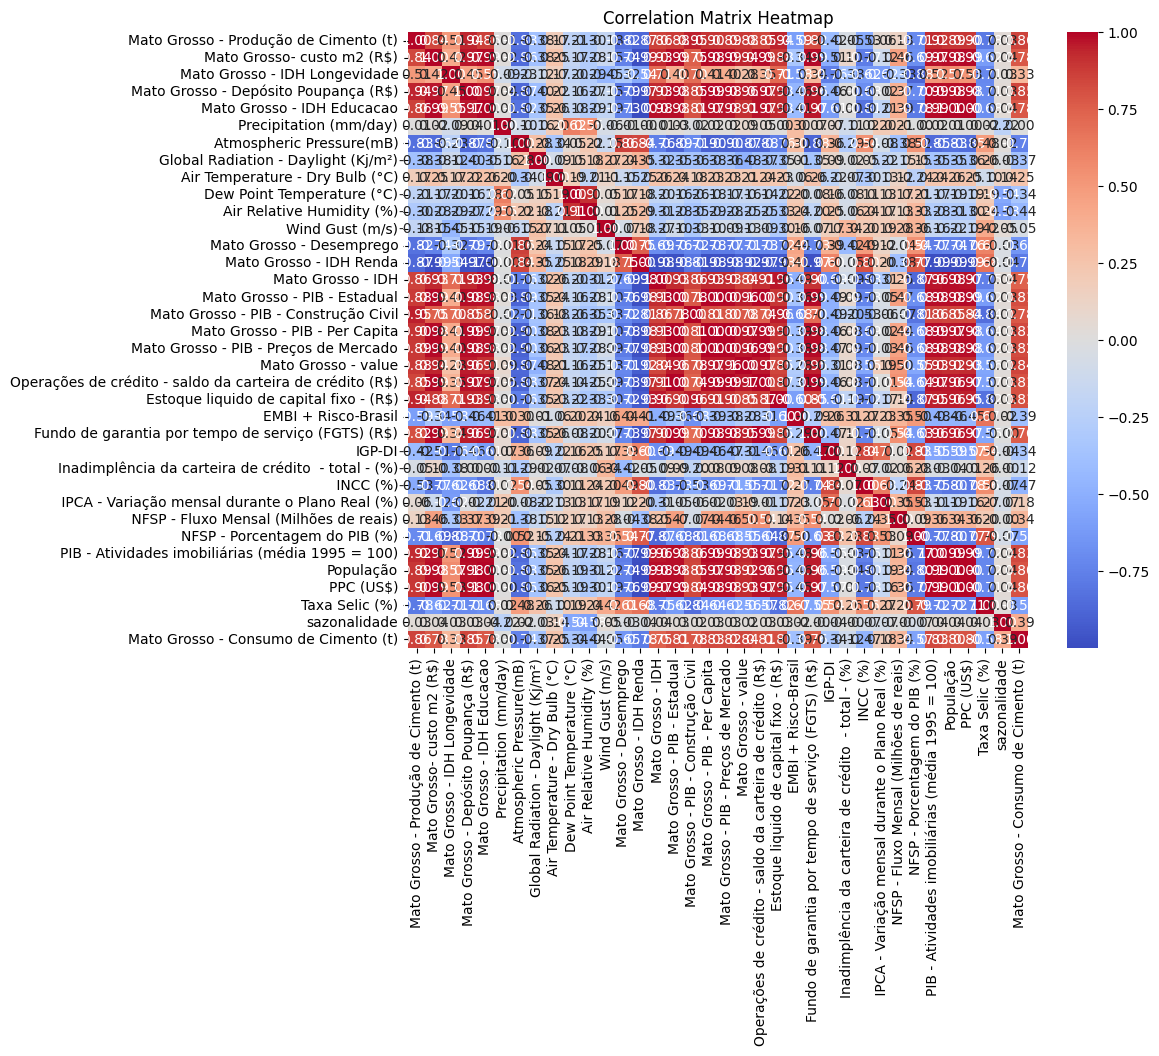

In [33]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [35]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Mato Grosso - Produção de Cimento (t),4.193063e+03
1,Mato Grosso- custo m2 (R$),1.191968e+05
2,Mato Grosso - IDH Longevidade,1.654550e+08
3,Mato Grosso - Depósito Poupança (R$),2.958512e+03
4,Mato Grosso - IDH Educacao,3.153060e+05
5,Precipitation (mm/day),6.585422e+00
6,Atmospheric Pressure(mB),3.158300e+02
7,Global Radiation - Daylight (Kj/m²),8.588159e+00
8,Air Temperature - Dry Bulb (°C),4.751015e+01
9,Dew Point Temperature (°C),3.921865e+02


In [36]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 9


,Mato Grosso - Produção de Cimento (t),Mato Grosso- custo m2 (R$),Mato Grosso - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - PIB - Estadual,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,50.917240,10522.560000,1.402870e+06,1.937098,994.641929,1307.693017,26.497759,22.112509,78.548056,2.038260,8.297178,6.084564e+07,0.331800,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,79.429412
1,50.851586,10614.965000,1.418219e+06,2.057965,994.309470,1283.219898,26.168996,21.331689,76.901685,1.862279,8.291317,6.092768e+07,0.333615,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,71.551986
2,50.970549,10702.843148,1.433568e+06,1.715492,994.660654,1261.062010,25.844852,20.557682,75.407092,1.802031,8.285457,6.100973e+07,0.334864,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,81.856015
3,51.049978,10785.405648,1.448917e+06,1.525801,995.244084,1235.995684,25.435732,19.399042,72.894611,1.794850,8.279596,6.109177e+07,0.336048,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,81.586671
4,51.567529,10863.369096,1.464267e+06,1.166060,995.697467,1233.790572,25.082755,17.830386,68.635209,1.820612,8.273735,6.117381e+07,0.336447,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,92.824887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,93.020506,25070.229116,3.945694e+06,1.959408,984.945139,411.383334,27.988217,16.228048,54.027651,1.612028,7.168497,7.669273e+07,0.425999,3.068648e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,416.859692,0.583985,106.747314
176,93.279675,25157.086306,3.965563e+06,2.203679,984.375423,489.714842,28.182340,17.275738,56.562487,1.667516,7.156691,7.670730e+07,0.425595,3.070265e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,417.748887,0.753312,100.948211
177,93.542939,25244.448372,3.985433e+06,2.157364,983.784543,595.944740,27.987389,18.771266,61.506408,1.692757,7.144884,7.672188e+07,0.425196,3.078615e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,418.601189,0.882343,107.233564
178,93.692873,25333.687204,4.005302e+06,2.324716,983.306264,641.656727,27.562555,19.780983,66.282897,1.645498,7.133078,7.673645e+07,0.424799,3.083099e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,419.430070,1.004174,97.163657


In [37]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Mato Grosso- custo m2 (R$),Mato Grosso - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - PIB - Estadual,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.000000,0.000000,0.336775,0.912870,0.080500,0.517405,1.000000,1.000000,0.943601,1.000000,0.000000,0.182887,0.000000,0.108706,0.015954,1.000000,0.790380,1.000000,1.000000,0.543630,1.000000,0.000000,0.000000,0.807549
1,0.006206,0.005853,0.359949,0.887077,0.078989,0.428403,0.903498,0.943223,0.859609,0.996341,0.005158,0.195974,0.000207,0.058377,0.005176,0.936603,0.788742,0.968765,0.909144,0.544990,0.965719,0.001689,0.003703,0.687691
2,0.012107,0.011707,0.294285,0.914322,0.077621,0.340651,0.807838,0.891680,0.830854,0.992682,0.010316,0.204977,0.000221,0.100305,0.001016,0.906543,0.788333,0.948151,0.853620,0.532585,0.927412,0.003378,0.007525,1.000000
3,0.017652,0.017560,0.257914,0.959586,0.076073,0.229895,0.664640,0.805034,0.827427,0.989023,0.015474,0.213516,0.000380,0.211591,0.000000,0.858675,0.787696,0.928398,0.828878,0.504220,0.885588,0.005067,0.011436,0.616940
4,0.022888,0.023413,0.188939,0.994760,0.075937,0.134338,0.470769,0.658143,0.839723,0.985364,0.020632,0.216392,0.000881,0.358835,0.002380,0.824839,0.784532,0.970256,0.796137,0.515509,0.838034,0.007149,0.015243,0.788236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.976990,0.969692,0.341052,0.160578,0.025157,0.920898,0.272734,0.154383,0.740170,0.295362,0.996335,0.862138,0.953376,0.201733,0.900757,0.168620,0.816187,0.020697,0.038179,0.496222,0.033352,0.973515,0.986889,0.043126
176,0.982823,0.977269,0.387888,0.116379,0.029993,0.973451,0.402219,0.241800,0.766653,0.287991,0.997252,0.859221,0.953950,0.191748,0.884182,0.176428,0.769775,0.019895,0.016717,0.473326,0.034217,0.980116,0.990433,0.169097
177,0.988690,0.984846,0.379008,0.070537,0.036553,0.920674,0.587053,0.412297,0.778700,0.280620,0.998168,0.856343,0.956916,0.184535,0.927328,0.174368,0.685140,0.020180,0.004270,0.425824,0.035996,0.986717,0.993830,0.265091
178,0.994683,0.992423,0.411095,0.033432,0.039375,0.805664,0.711845,0.577021,0.756145,0.273250,0.999084,0.853480,0.958509,0.179849,0.981078,0.197726,0.619023,0.007298,0.000000,0.448015,0.039184,0.993358,0.997134,0.355727


In [38]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Mato Grosso- custo m2 (R$),Mato Grosso - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - PIB - Estadual,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.000000,0.000000,0.336775,0.912870,0.080500,0.517405,1.000000,1.000000,0.943601,1.000000,0.000000,0.182887,0.000000,0.108706,0.015954,1.000000,0.790380,1.000000,1.000000,0.543630,1.000000,0.000000,0.000000,0.807549
1,0.006206,0.005853,0.359949,0.887077,0.078989,0.428403,0.903498,0.943223,0.859609,0.996341,0.005158,0.195974,0.000207,0.058377,0.005176,0.936603,0.788742,0.968765,0.909144,0.544990,0.965719,0.001689,0.003703,0.687691
2,0.012107,0.011707,0.294285,0.914322,0.077621,0.340651,0.807838,0.891680,0.830854,0.992682,0.010316,0.204977,0.000221,0.100305,0.001016,0.906543,0.788333,0.948151,0.853620,0.532585,0.927412,0.003378,0.007525,1.000000
3,0.017652,0.017560,0.257914,0.959586,0.076073,0.229895,0.664640,0.805034,0.827427,0.989023,0.015474,0.213516,0.000380,0.211591,0.000000,0.858675,0.787696,0.928398,0.828878,0.504220,0.885588,0.005067,0.011436,0.616940
4,0.022888,0.023413,0.188939,0.994760,0.075937,0.134338,0.470769,0.658143,0.839723,0.985364,0.020632,0.216392,0.000881,0.358835,0.002380,0.824839,0.784532,0.970256,0.796137,0.515509,0.838034,0.007149,0.015243,0.788236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.904408,0.882746,0.401227,0.212355,0.025275,0.461696,0.354214,0.392980,0.778020,0.471747,0.982655,0.896453,0.973534,0.423280,0.849212,0.061396,0.803166,0.094130,0.144755,0.772284,0.015040,0.918734,0.938086,0.461869
164,0.909906,0.889527,0.472099,0.160443,0.029844,0.474079,0.489885,0.506335,0.769685,0.446789,0.984109,0.888864,0.971665,0.387661,0.842872,0.095565,0.850835,0.087555,0.133956,0.741958,0.016631,0.921412,0.942492,0.424663
165,0.915884,0.896308,0.490395,0.104751,0.035128,0.488721,0.620823,0.622254,0.755205,0.421831,0.985562,0.886064,0.970441,0.351781,0.895026,0.096417,0.875483,0.083404,0.141095,0.686725,0.018850,0.924089,0.946808,0.397941
166,0.922006,0.903090,0.485126,0.080486,0.037378,0.442582,0.725051,0.743940,0.745407,0.396873,0.987015,0.883151,0.968444,0.319424,0.964451,0.052056,0.869042,0.075773,0.102393,0.792808,0.020846,0.926628,0.951146,0.462657


In [39]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       55.998
1       49.346
2       57.277
3       61.881
4       65.040
        ...   
163    142.145
164    121.124
165    130.503
166    104.115
167     90.690
Name: Mato Grosso - Consumo de Cimento (t), Length: 168, dtype: float64

In [40]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Mato Grosso- custo m2 (R$),Mato Grosso - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - PIB - Estadual,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
168,0.934563,0.916652,0.439754,0.082685,0.034277,0.449749,0.841987,0.854188,0.707828,0.346958,0.989922,0.877772,0.962638,0.283118,0.986806,0.000000,0.889227,0.069347,0.074497,0.570406,0.021611,0.931705,0.961303,0.175647
169,0.940781,0.924229,0.422057,0.100052,0.029508,0.478461,0.869340,0.867085,0.686232,0.339587,0.990839,0.875341,0.961214,0.264760,0.932747,0.016581,0.931271,0.053238,0.063484,0.662082,0.022418,0.938460,0.965012,0.205085
170,0.946984,0.931806,0.347759,0.148869,0.024826,0.422356,0.781249,0.800752,0.670642,0.332216,0.991755,0.872897,0.959958,0.247870,0.921357,0.039471,1.000000,0.036342,0.073462,0.619766,0.023626,0.945215,0.968631,0.215039
171,0.952921,0.939383,0.267654,0.226990,0.020405,0.342415,0.568715,0.633350,0.670108,0.324845,0.992671,0.871972,0.959405,0.235968,0.903144,0.071391,0.999350,0.038159,0.079120,0.573937,0.025114,0.951969,0.972311,0.198268
172,0.959189,0.946960,0.228108,0.253825,0.018008,0.401314,0.389818,0.450556,0.674108,0.317475,0.993587,0.869636,0.957811,0.227032,0.903553,0.116194,0.967357,0.034746,0.068002,0.614331,0.026878,0.956951,0.975938,0.096831
173,0.965364,0.954538,0.225444,0.272628,0.017633,0.521050,0.178827,0.226110,0.688695,0.310104,0.994503,0.867338,0.956399,0.218840,0.904612,0.147729,0.896216,0.037948,0.041121,0.571163,0.028767,0.961932,0.979658,0.373433
174,0.971199,0.962115,0.270057,0.248470,0.019402,0.742006,0.144406,0.109552,0.723641,0.302733,0.995419,0.865087,0.953910,0.212247,0.901042,0.175013,0.850884,0.021004,0.054321,0.515909,0.030836,0.966913,0.983261,0.099521
175,0.976990,0.969692,0.341052,0.160578,0.025157,0.920898,0.272734,0.154383,0.740170,0.295362,0.996335,0.862138,0.953376,0.201733,0.900757,0.168620,0.816187,0.020697,0.038179,0.496222,0.033352,0.973515,0.986889,0.043126
176,0.982823,0.977269,0.387888,0.116379,0.029993,0.973451,0.402219,0.241800,0.766653,0.287991,0.997252,0.859221,0.953950,0.191748,0.884182,0.176428,0.769775,0.019895,0.016717,0.473326,0.034217,0.980116,0.990433,0.169097
177,0.988690,0.984846,0.379008,0.070537,0.036553,0.920674,0.587053,0.412297,0.778700,0.280620,0.998168,0.856343,0.956916,0.184535,0.927328,0.174368,0.685140,0.020180,0.004270,0.425824,0.035996,0.986717,0.993830,0.265091


In [41]:
# Alvo para teste
test_target = target_data.iloc[train_split - window_size:split_index + 1]
test_target

168    102.685
169     96.144
170    102.197
171    106.712
172    124.057
173    124.625
174    133.116
175    144.310
176    140.357
177    152.769
178    124.038
179     95.054
Name: Mato Grosso - Consumo de Cimento (t), dtype: float64

In [42]:
# Rede neural feed-forward com optmizador Estocástico
def neural_network_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2(0.01), 
                              input_shape=(train_input.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train_input, 
                      train_target, 
                      epochs=10000,
                      validation_data=(train_input.iloc[-1:], train_target.iloc[-1:]),
                      callbacks=[early_stopping], 
                      verbose=want_verbose)
    return model, history

In [43]:
def get_a_good_seed(train_input, train_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = neural_network_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")

    return winner_seed

In [44]:
winner_seed = get_a_good_seed(train_input, train_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2006896387, 1845876163, 2232114134, 1871509086, 1566622573, 815593514, 2080063910, 444278842, 1493826409, 2568361674]


Step: 0 ___________________________________________
val_loss: 5.572691917419434
winner_seed: 2006896387


Step: 1 ___________________________________________
val_loss: 1.9945050477981567
winner_seed: 1845876163


Step: 2 ___________________________________________
val_loss: 4.076536178588867


Step: 3 ___________________________________________
val_loss: 4.918972969055176


Step: 4 ___________________________________________
val_loss: 0.9701915979385376
winner_seed: 1566622573


Step: 5 ___________________________________________
val_loss: 3.0099000930786133


Step: 6 ___________________________________________
val_loss: 4.64587926864624


Step: 7 ___________________________________________
val_loss: 3.451636552810669


Step: 8 ___________________________________________
val_loss: 1.8401840925216675


Step: 9 ___________________________________________
val_loss: 3.15

In [45]:
trained_model, history = neural_network_model(train_input, train_target, want_verbose=1, seed=winner_seed)

Epoch 1/10000
6/6 [==============================] - 0s 19ms/step - loss: 5525.9839 - val_loss: 26.2501
Epoch 2/10000
6/6 [==============================] - 0s 4ms/step - loss: 897.0465 - val_loss: 35.7842
Epoch 3/10000
6/6 [==============================] - 0s 4ms/step - loss: 838.7671 - val_loss: 155.1892
Epoch 4/10000
6/6 [==============================] - 0s 5ms/step - loss: 852.1660 - val_loss: 246.5940
Epoch 5/10000
6/6 [==============================] - 0s 4ms/step - loss: 848.1611 - val_loss: 78.7934
Epoch 6/10000
6/6 [==============================] - 0s 4ms/step - loss: 835.7874 - val_loss: 270.9106
Epoch 7/10000
6/6 [==============================] - 0s 5ms/step - loss: 854.9626 - val_loss: 47.8022
Epoch 8/10000
6/6 [==============================] - 0s 4ms/step - loss: 832.4435 - val_loss: 110.3414
Epoch 9/10000
6/6 [==============================] - 0s 4ms/step - loss: 841.2212 - val_loss: 21.3907
Epoch 10/10000
6/6 [==============================] - 0s 4ms/step - loss: 83

6/6 [==============================] - 0s 5ms/step - loss: 851.3267 - val_loss: 41.7370
Epoch 81/10000
6/6 [==============================] - 0s 4ms/step - loss: 848.5538 - val_loss: 65.3878
Epoch 82/10000
6/6 [==============================] - 0s 4ms/step - loss: 849.9190 - val_loss: 132.6759
Epoch 83/10000
6/6 [==============================] - 0s 4ms/step - loss: 853.6611 - val_loss: 140.2218
Epoch 84/10000
6/6 [==============================] - 0s 5ms/step - loss: 851.0714 - val_loss: 70.3794
Epoch 85/10000
6/6 [==============================] - 0s 4ms/step - loss: 848.7844 - val_loss: 138.3102
Epoch 86/10000
6/6 [==============================] - 0s 4ms/step - loss: 856.3035 - val_loss: 137.5103
Epoch 87/10000
6/6 [==============================] - 0s 4ms/step - loss: 849.0361 - val_loss: 90.7124
Epoch 88/10000
6/6 [==============================] - 0s 4ms/step - loss: 850.2823 - val_loss: 65.3163
Epoch 89/10000
6/6 [==============================] - 0s 4ms/step - loss: 855.3218 -

Epoch 159/10000
6/6 [==============================] - 0s 4ms/step - loss: 842.7347 - val_loss: 100.7707
Epoch 160/10000
6/6 [==============================] - 0s 4ms/step - loss: 842.1360 - val_loss: 54.5535
Epoch 161/10000
6/6 [==============================] - 0s 4ms/step - loss: 855.6382 - val_loss: 43.0630
Epoch 162/10000
6/6 [==============================] - 0s 4ms/step - loss: 858.1866 - val_loss: 81.3848
Epoch 163/10000
6/6 [==============================] - 0s 4ms/step - loss: 848.9875 - val_loss: 45.0507
Epoch 164/10000
6/6 [==============================] - 0s 4ms/step - loss: 847.1227 - val_loss: 120.4899
Epoch 165/10000
6/6 [==============================] - 0s 4ms/step - loss: 849.0842 - val_loss: 29.4719
Epoch 166/10000
6/6 [==============================] - 0s 4ms/step - loss: 857.1204 - val_loss: 68.6953
Epoch 167/10000
6/6 [==============================] - 0s 4ms/step - loss: 844.6699 - val_loss: 71.0651
Epoch 168/10000
6/6 [==============================] - 0s 4ms/

6/6 [==============================] - 0s 4ms/step - loss: 848.8154 - val_loss: 78.7684
Epoch 238/10000
6/6 [==============================] - 0s 4ms/step - loss: 845.4489 - val_loss: 140.1168
Epoch 239/10000
6/6 [==============================] - 0s 4ms/step - loss: 852.5208 - val_loss: 134.7883
Epoch 240/10000
6/6 [==============================] - 0s 4ms/step - loss: 841.8046 - val_loss: 36.6834
Epoch 241/10000
6/6 [==============================] - 0s 5ms/step - loss: 845.6252 - val_loss: 341.0287
Epoch 242/10000
6/6 [==============================] - 0s 4ms/step - loss: 894.1115 - val_loss: 93.6095
Epoch 243/10000
6/6 [==============================] - 0s 4ms/step - loss: 841.7106 - val_loss: 29.5142
Epoch 244/10000
6/6 [==============================] - 0s 4ms/step - loss: 845.6776 - val_loss: 46.5380
Epoch 245/10000
6/6 [==============================] - 0s 4ms/step - loss: 843.8604 - val_loss: 84.9775
Epoch 246/10000
6/6 [==============================] - 0s 4ms/step - loss: 84

6/6 [==============================] - 0s 4ms/step - loss: 841.8145 - val_loss: 99.1082
Epoch 316/10000
6/6 [==============================] - 0s 4ms/step - loss: 847.0974 - val_loss: 58.8991
Epoch 317/10000
6/6 [==============================] - 0s 4ms/step - loss: 840.6903 - val_loss: 59.4437
Epoch 318/10000
6/6 [==============================] - 0s 4ms/step - loss: 838.7056 - val_loss: 101.3557
Epoch 319/10000
6/6 [==============================] - 0s 5ms/step - loss: 846.1971 - val_loss: 93.5302
Epoch 320/10000
6/6 [==============================] - 0s 5ms/step - loss: 839.2763 - val_loss: 60.2266
Epoch 321/10000
6/6 [==============================] - 0s 4ms/step - loss: 838.9117 - val_loss: 155.6321
Epoch 322/10000
6/6 [==============================] - 0s 4ms/step - loss: 849.0579 - val_loss: 73.8111
Epoch 323/10000
6/6 [==============================] - 0s 4ms/step - loss: 841.8785 - val_loss: 72.4893
Epoch 324/10000
6/6 [==============================] - 0s 4ms/step - loss: 854

6/6 [==============================] - 0s 4ms/step - loss: 850.0501 - val_loss: 72.8530
Epoch 394/10000
6/6 [==============================] - 0s 4ms/step - loss: 847.8840 - val_loss: 45.0589
Epoch 395/10000
6/6 [==============================] - 0s 4ms/step - loss: 844.1896 - val_loss: 52.4896
Epoch 396/10000
6/6 [==============================] - 0s 4ms/step - loss: 840.1444 - val_loss: 51.8570
Epoch 397/10000
6/6 [==============================] - 0s 4ms/step - loss: 845.5478 - val_loss: 54.2209
Epoch 398/10000
6/6 [==============================] - 0s 4ms/step - loss: 846.9623 - val_loss: 91.3960
Epoch 399/10000
6/6 [==============================] - 0s 4ms/step - loss: 839.1467 - val_loss: 34.2542
Epoch 400/10000
6/6 [==============================] - 0s 4ms/step - loss: 854.5070 - val_loss: 166.4701
Epoch 401/10000
6/6 [==============================] - 0s 4ms/step - loss: 851.9824 - val_loss: 137.7352
Epoch 402/10000
6/6 [==============================] - 0s 5ms/step - loss: 872

6/6 [==============================] - 0s 5ms/step - loss: 843.2622 - val_loss: 195.8068
Epoch 472/10000
6/6 [==============================] - 0s 5ms/step - loss: 857.2640 - val_loss: 202.4544
Epoch 473/10000
6/6 [==============================] - 0s 4ms/step - loss: 856.1793 - val_loss: 167.2015
Epoch 474/10000
6/6 [==============================] - 0s 4ms/step - loss: 846.0888 - val_loss: 143.7282
Epoch 475/10000
6/6 [==============================] - 0s 5ms/step - loss: 852.0417 - val_loss: 98.1543
Epoch 476/10000
6/6 [==============================] - 0s 5ms/step - loss: 840.0743 - val_loss: 153.5736
Epoch 477/10000
6/6 [==============================] - 0s 4ms/step - loss: 852.5139 - val_loss: 117.8421
Epoch 478/10000
6/6 [==============================] - 0s 5ms/step - loss: 842.7834 - val_loss: 117.1777
Epoch 479/10000
6/6 [==============================] - 0s 4ms/step - loss: 845.3086 - val_loss: 57.7949
Epoch 480/10000
6/6 [==============================] - 0s 4ms/step - loss

6/6 [==============================] - 0s 5ms/step - loss: 837.2921 - val_loss: 46.3887
Epoch 550/10000
6/6 [==============================] - 0s 5ms/step - loss: 842.8571 - val_loss: 88.9228
Epoch 551/10000
6/6 [==============================] - 0s 5ms/step - loss: 843.2054 - val_loss: 24.4761
Epoch 552/10000
6/6 [==============================] - 0s 5ms/step - loss: 851.6403 - val_loss: 105.6847
Epoch 553/10000
6/6 [==============================] - 0s 4ms/step - loss: 845.7916 - val_loss: 19.6928
Epoch 554/10000
6/6 [==============================] - 0s 5ms/step - loss: 854.2374 - val_loss: 142.0127
Epoch 555/10000
6/6 [==============================] - 0s 4ms/step - loss: 875.9675 - val_loss: 199.0423
Epoch 556/10000
6/6 [==============================] - 0s 5ms/step - loss: 856.7559 - val_loss: 51.9350
Epoch 557/10000
6/6 [==============================] - 0s 5ms/step - loss: 841.0609 - val_loss: 146.5418
Epoch 558/10000
6/6 [==============================] - 0s 4ms/step - loss: 8

6/6 [==============================] - 0s 5ms/step - loss: 851.0993 - val_loss: 39.5931
Epoch 628/10000
6/6 [==============================] - 0s 5ms/step - loss: 843.3374 - val_loss: 160.8306
Epoch 629/10000
6/6 [==============================] - 0s 5ms/step - loss: 860.6754 - val_loss: 89.8352
Epoch 630/10000
6/6 [==============================] - 0s 5ms/step - loss: 837.3759 - val_loss: 68.0947
Epoch 631/10000
6/6 [==============================] - 0s 5ms/step - loss: 839.8047 - val_loss: 63.4749
Epoch 632/10000
6/6 [==============================] - 0s 4ms/step - loss: 834.8478 - val_loss: 80.4539
Epoch 633/10000
6/6 [==============================] - 0s 5ms/step - loss: 842.7634 - val_loss: 61.6422
Epoch 634/10000
6/6 [==============================] - 0s 4ms/step - loss: 846.5854 - val_loss: 61.5133
Epoch 635/10000
6/6 [==============================] - 0s 5ms/step - loss: 836.8246 - val_loss: 137.7105
Epoch 636/10000
6/6 [==============================] - 0s 5ms/step - loss: 844

Epoch 706/10000
6/6 [==============================] - 0s 5ms/step - loss: 842.8740 - val_loss: 46.4698
Epoch 707/10000
6/6 [==============================] - 0s 5ms/step - loss: 839.3817 - val_loss: 34.6618
Epoch 708/10000
6/6 [==============================] - 0s 5ms/step - loss: 842.5508 - val_loss: 32.1136
Epoch 709/10000
6/6 [==============================] - 0s 5ms/step - loss: 839.1911 - val_loss: 38.0579
Epoch 710/10000
6/6 [==============================] - 0s 5ms/step - loss: 840.2302 - val_loss: 63.9043
Epoch 711/10000
6/6 [==============================] - 0s 5ms/step - loss: 837.5519 - val_loss: 105.0846
Epoch 712/10000
6/6 [==============================] - 0s 5ms/step - loss: 837.7573 - val_loss: 51.3992
Epoch 713/10000
6/6 [==============================] - 0s 5ms/step - loss: 841.4202 - val_loss: 49.5804
Epoch 714/10000
6/6 [==============================] - 0s 5ms/step - loss: 840.2596 - val_loss: 26.5579
Epoch 715/10000
6/6 [==============================] - 0s 5ms/s

6/6 [==============================] - 0s 4ms/step - loss: 840.9742 - val_loss: 39.2121
Epoch 785/10000
6/6 [==============================] - 0s 5ms/step - loss: 846.6247 - val_loss: 107.1039
Epoch 786/10000
6/6 [==============================] - 0s 4ms/step - loss: 838.9257 - val_loss: 37.3065
Epoch 787/10000
6/6 [==============================] - 0s 5ms/step - loss: 836.9512 - val_loss: 41.9788
Epoch 788/10000
6/6 [==============================] - 0s 5ms/step - loss: 838.6880 - val_loss: 38.1872
Epoch 789/10000
6/6 [==============================] - 0s 5ms/step - loss: 839.9329 - val_loss: 97.3863
Epoch 790/10000
6/6 [==============================] - 0s 5ms/step - loss: 837.5861 - val_loss: 79.3701
Epoch 791/10000
6/6 [==============================] - 0s 5ms/step - loss: 833.2971 - val_loss: 45.6584
Epoch 792/10000
6/6 [==============================] - 0s 5ms/step - loss: 852.1138 - val_loss: 160.0689
Epoch 793/10000
6/6 [==============================] - 0s 5ms/step - loss: 846

6/6 [==============================] - 0s 5ms/step - loss: 847.6525 - val_loss: 51.1696
Epoch 863/10000
6/6 [==============================] - 0s 4ms/step - loss: 840.6935 - val_loss: 44.3593
Epoch 864/10000
6/6 [==============================] - 0s 5ms/step - loss: 843.1447 - val_loss: 46.2752
Epoch 865/10000
6/6 [==============================] - 0s 5ms/step - loss: 837.5430 - val_loss: 44.8843
Epoch 866/10000
6/6 [==============================] - 0s 5ms/step - loss: 845.0712 - val_loss: 39.3377
Epoch 867/10000
6/6 [==============================] - 0s 4ms/step - loss: 840.2130 - val_loss: 84.3152
Epoch 868/10000
6/6 [==============================] - 0s 5ms/step - loss: 845.0280 - val_loss: 93.8271
Epoch 869/10000
6/6 [==============================] - 0s 6ms/step - loss: 843.4048 - val_loss: 183.6427
Epoch 870/10000
6/6 [==============================] - 0s 5ms/step - loss: 838.6247 - val_loss: 57.9751
Epoch 871/10000
6/6 [==============================] - 0s 4ms/step - loss: 840.

Epoch 941/10000
6/6 [==============================] - 0s 5ms/step - loss: 832.8503 - val_loss: 52.2655
Epoch 942/10000
6/6 [==============================] - 0s 5ms/step - loss: 835.2197 - val_loss: 52.3005
Epoch 943/10000
6/6 [==============================] - 0s 5ms/step - loss: 837.6195 - val_loss: 118.1476
Epoch 944/10000
6/6 [==============================] - 0s 5ms/step - loss: 840.8582 - val_loss: 71.7625
Epoch 945/10000
6/6 [==============================] - 0s 5ms/step - loss: 837.8185 - val_loss: 76.5146
Epoch 946/10000
6/6 [==============================] - 0s 5ms/step - loss: 850.5586 - val_loss: 143.0880
Epoch 947/10000
6/6 [==============================] - 0s 5ms/step - loss: 838.4905 - val_loss: 6.4267
Epoch 948/10000
6/6 [==============================] - 0s 4ms/step - loss: 856.5936 - val_loss: 106.3845
Epoch 949/10000
6/6 [==============================] - 0s 5ms/step - loss: 850.6674 - val_loss: 137.5567
Epoch 950/10000
6/6 [==============================] - 0s 5ms

6/6 [==============================] - 0s 5ms/step - loss: 864.7907 - val_loss: 72.1994
Epoch 1020/10000
6/6 [==============================] - 0s 4ms/step - loss: 838.5212 - val_loss: 39.9625
Epoch 1021/10000
6/6 [==============================] - 0s 5ms/step - loss: 844.2196 - val_loss: 16.7989
Epoch 1022/10000
6/6 [==============================] - 0s 5ms/step - loss: 839.3854 - val_loss: 24.8124
Epoch 1023/10000
6/6 [==============================] - 0s 4ms/step - loss: 840.2742 - val_loss: 22.7134
Epoch 1024/10000
6/6 [==============================] - 0s 4ms/step - loss: 837.7394 - val_loss: 54.4255
Epoch 1025/10000
6/6 [==============================] - 0s 5ms/step - loss: 847.9036 - val_loss: 165.3667
Epoch 1026/10000
6/6 [==============================] - 0s 5ms/step - loss: 843.1625 - val_loss: 34.5912
Epoch 1027/10000
6/6 [==============================] - 0s 5ms/step - loss: 833.0671 - val_loss: 172.2937
Epoch 1028/10000
6/6 [==============================] - 0s 4ms/step - 

6/6 [==============================] - 0s 4ms/step - loss: 831.3807 - val_loss: 70.3997
Epoch 1098/10000
6/6 [==============================] - 0s 5ms/step - loss: 838.7193 - val_loss: 114.0344
Epoch 1099/10000
6/6 [==============================] - 0s 4ms/step - loss: 837.4608 - val_loss: 42.5446
Epoch 1100/10000
6/6 [==============================] - 0s 4ms/step - loss: 845.9662 - val_loss: 27.6914
Epoch 1101/10000
6/6 [==============================] - 0s 5ms/step - loss: 844.4217 - val_loss: 66.7626
Epoch 1102/10000
6/6 [==============================] - 0s 5ms/step - loss: 833.2129 - val_loss: 105.0984
Epoch 1103/10000
6/6 [==============================] - 0s 5ms/step - loss: 835.9509 - val_loss: 74.5732
Epoch 1104/10000
6/6 [==============================] - 0s 5ms/step - loss: 833.0851 - val_loss: 53.4322
Epoch 1105/10000
6/6 [==============================] - 0s 5ms/step - loss: 835.1900 - val_loss: 37.8912
Epoch 1106/10000
6/6 [==============================] - 0s 5ms/step - 

6/6 [==============================] - 0s 4ms/step - loss: 841.7470 - val_loss: 52.3317
Epoch 1176/10000
6/6 [==============================] - 0s 4ms/step - loss: 837.2345 - val_loss: 43.1249
Epoch 1177/10000
6/6 [==============================] - 0s 5ms/step - loss: 838.2198 - val_loss: 50.3042
Epoch 1178/10000
6/6 [==============================] - 0s 4ms/step - loss: 836.0261 - val_loss: 56.3612
Epoch 1179/10000
6/6 [==============================] - 0s 5ms/step - loss: 844.6502 - val_loss: 7.8786
Epoch 1180/10000
6/6 [==============================] - 0s 4ms/step - loss: 848.8796 - val_loss: 28.3335
Epoch 1181/10000
6/6 [==============================] - 0s 4ms/step - loss: 835.5980 - val_loss: 43.0719
Epoch 1182/10000
6/6 [==============================] - 0s 4ms/step - loss: 836.2042 - val_loss: 27.0931
Epoch 1183/10000
6/6 [==============================] - 0s 5ms/step - loss: 844.3268 - val_loss: 61.8061
Epoch 1184/10000
6/6 [==============================] - 0s 4ms/step - los

6/6 [==============================] - 0s 4ms/step - loss: 838.4047 - val_loss: 96.9251
Epoch 1254/10000
6/6 [==============================] - 0s 5ms/step - loss: 831.1745 - val_loss: 31.4891
Epoch 1255/10000
6/6 [==============================] - 0s 5ms/step - loss: 839.7737 - val_loss: 47.3473
Epoch 1256/10000
6/6 [==============================] - 0s 4ms/step - loss: 838.8177 - val_loss: 50.6314
Epoch 1257/10000
6/6 [==============================] - 0s 5ms/step - loss: 839.6060 - val_loss: 23.8492
Epoch 1258/10000
6/6 [==============================] - 0s 5ms/step - loss: 835.9867 - val_loss: 29.0057
Epoch 1259/10000
6/6 [==============================] - 0s 4ms/step - loss: 836.9481 - val_loss: 70.3837
Epoch 1260/10000
6/6 [==============================] - 0s 4ms/step - loss: 834.8304 - val_loss: 56.1551
Epoch 1261/10000
6/6 [==============================] - 0s 4ms/step - loss: 832.3273 - val_loss: 94.9693
Epoch 1262/10000
6/6 [==============================] - 0s 5ms/step - lo

6/6 [==============================] - 0s 4ms/step - loss: 839.1247 - val_loss: 130.5632
Epoch 1332/10000
6/6 [==============================] - 0s 5ms/step - loss: 846.1069 - val_loss: 101.5111
Epoch 1333/10000
6/6 [==============================] - 0s 4ms/step - loss: 843.7198 - val_loss: 78.3151
Epoch 1334/10000
6/6 [==============================] - 0s 4ms/step - loss: 836.6638 - val_loss: 105.2795
Epoch 1335/10000
6/6 [==============================] - 0s 4ms/step - loss: 833.6470 - val_loss: 33.9842
Epoch 1336/10000
6/6 [==============================] - 0s 4ms/step - loss: 832.7252 - val_loss: 49.4381
Epoch 1337/10000
6/6 [==============================] - 0s 4ms/step - loss: 833.6958 - val_loss: 61.1538
Epoch 1338/10000
6/6 [==============================] - 0s 4ms/step - loss: 832.6157 - val_loss: 100.6932
Epoch 1339/10000
6/6 [==============================] - 0s 4ms/step - loss: 842.3004 - val_loss: 94.7096
Epoch 1340/10000
6/6 [==============================] - 0s 4ms/step 

Epoch 1409/10000
6/6 [==============================] - 0s 5ms/step - loss: 833.6678 - val_loss: 45.0830
Epoch 1410/10000
6/6 [==============================] - 0s 4ms/step - loss: 834.7103 - val_loss: 15.8511
Epoch 1411/10000
6/6 [==============================] - 0s 4ms/step - loss: 836.6234 - val_loss: 48.9057
Epoch 1412/10000
6/6 [==============================] - 0s 4ms/step - loss: 831.0557 - val_loss: 137.5071
Epoch 1413/10000
6/6 [==============================] - 0s 5ms/step - loss: 838.8221 - val_loss: 143.1856
Epoch 1414/10000
6/6 [==============================] - 0s 4ms/step - loss: 838.8229 - val_loss: 52.5979
Epoch 1415/10000
6/6 [==============================] - 0s 4ms/step - loss: 833.7816 - val_loss: 17.4285
Epoch 1416/10000
6/6 [==============================] - 0s 4ms/step - loss: 848.9645 - val_loss: 292.6451
Epoch 1417/10000
6/6 [==============================] - 0s 5ms/step - loss: 860.5568 - val_loss: 18.1209
Epoch 1418/10000
6/6 [==============================

Epoch 1487/10000
6/6 [==============================] - 0s 4ms/step - loss: 859.1920 - val_loss: 163.2571
Epoch 1488/10000
6/6 [==============================] - 0s 5ms/step - loss: 853.0192 - val_loss: 93.7952
Epoch 1489/10000
6/6 [==============================] - 0s 4ms/step - loss: 836.1625 - val_loss: 17.4717
Epoch 1490/10000
6/6 [==============================] - 0s 4ms/step - loss: 848.8839 - val_loss: 7.6264
Epoch 1491/10000
6/6 [==============================] - 0s 4ms/step - loss: 845.7864 - val_loss: 53.3459
Epoch 1492/10000
6/6 [==============================] - 0s 4ms/step - loss: 837.5607 - val_loss: 100.0323
Epoch 1493/10000
6/6 [==============================] - 0s 4ms/step - loss: 832.3300 - val_loss: 90.5248
Epoch 1494/10000
6/6 [==============================] - 0s 4ms/step - loss: 843.0513 - val_loss: 53.4364
Epoch 1495/10000
6/6 [==============================] - 0s 4ms/step - loss: 833.5364 - val_loss: 153.6784
Epoch 1496/10000
6/6 [==============================]

Epoch 1565/10000
6/6 [==============================] - 0s 5ms/step - loss: 840.9311 - val_loss: 157.8595
Epoch 1566/10000
6/6 [==============================] - 0s 4ms/step - loss: 848.0007 - val_loss: 47.0913
Epoch 1567/10000
6/6 [==============================] - 0s 4ms/step - loss: 831.0769 - val_loss: 127.4583
Epoch 1568/10000
6/6 [==============================] - 0s 4ms/step - loss: 839.2440 - val_loss: 47.0434
Epoch 1569/10000
6/6 [==============================] - 0s 4ms/step - loss: 838.0250 - val_loss: 16.1228
Epoch 1570/10000
6/6 [==============================] - 0s 5ms/step - loss: 845.1274 - val_loss: 64.8011
Epoch 1571/10000
6/6 [==============================] - 0s 4ms/step - loss: 834.1879 - val_loss: 217.1648
Epoch 1572/10000
6/6 [==============================] - 0s 4ms/step - loss: 844.1479 - val_loss: 33.3198
Epoch 1573/10000
6/6 [==============================] - 0s 5ms/step - loss: 836.3693 - val_loss: 33.8816
Epoch 1574/10000
6/6 [==============================

Epoch 1643/10000
6/6 [==============================] - 0s 4ms/step - loss: 849.2225 - val_loss: 220.3335
Epoch 1644/10000
6/6 [==============================] - 0s 4ms/step - loss: 852.1346 - val_loss: 107.8492
Epoch 1645/10000
6/6 [==============================] - 0s 4ms/step - loss: 831.8245 - val_loss: 95.8537
Epoch 1646/10000
6/6 [==============================] - 0s 4ms/step - loss: 830.9033 - val_loss: 143.7145
Epoch 1647/10000
6/6 [==============================] - 0s 4ms/step - loss: 841.3100 - val_loss: 41.7259
Epoch 1648/10000
6/6 [==============================] - 0s 5ms/step - loss: 844.9405 - val_loss: 67.0534
Epoch 1649/10000
6/6 [==============================] - 0s 5ms/step - loss: 831.6149 - val_loss: 33.2266
Epoch 1650/10000
6/6 [==============================] - 0s 4ms/step - loss: 837.3780 - val_loss: 28.7082
Epoch 1651/10000
6/6 [==============================] - 0s 4ms/step - loss: 838.2423 - val_loss: 24.0201
Epoch 1652/10000
6/6 [==============================

Epoch 1721/10000
6/6 [==============================] - 0s 4ms/step - loss: 838.3591 - val_loss: 178.8946
Epoch 1722/10000
6/6 [==============================] - 0s 4ms/step - loss: 846.1847 - val_loss: 81.4867
Epoch 1723/10000
6/6 [==============================] - 0s 4ms/step - loss: 835.3345 - val_loss: 180.0097
Epoch 1724/10000
6/6 [==============================] - 0s 5ms/step - loss: 847.0009 - val_loss: 193.7463
Epoch 1725/10000
6/6 [==============================] - 0s 4ms/step - loss: 846.3389 - val_loss: 134.5132
Epoch 1726/10000
6/6 [==============================] - 0s 4ms/step - loss: 835.4822 - val_loss: 26.2608
Epoch 1727/10000
6/6 [==============================] - 0s 4ms/step - loss: 833.8347 - val_loss: 109.3585
Epoch 1728/10000
6/6 [==============================] - 0s 5ms/step - loss: 855.7628 - val_loss: 71.1834
Epoch 1729/10000
6/6 [==============================] - 0s 5ms/step - loss: 832.3532 - val_loss: 164.8151
Epoch 1730/10000
6/6 [===========================

Epoch 1799/10000
6/6 [==============================] - 0s 4ms/step - loss: 841.3702 - val_loss: 64.1732
Epoch 1800/10000
6/6 [==============================] - 0s 5ms/step - loss: 834.5895 - val_loss: 103.1853
Epoch 1801/10000
6/6 [==============================] - 0s 4ms/step - loss: 829.6166 - val_loss: 36.5380
Epoch 1802/10000
6/6 [==============================] - 0s 4ms/step - loss: 841.8084 - val_loss: 66.3006
Epoch 1803/10000
6/6 [==============================] - 0s 4ms/step - loss: 832.1569 - val_loss: 30.6151
Epoch 1804/10000
6/6 [==============================] - 0s 4ms/step - loss: 833.7949 - val_loss: 67.6773
Epoch 1805/10000
6/6 [==============================] - 0s 4ms/step - loss: 828.7640 - val_loss: 32.3073
Epoch 1806/10000
6/6 [==============================] - 0s 4ms/step - loss: 833.9467 - val_loss: 41.3686
Epoch 1807/10000
6/6 [==============================] - 0s 4ms/step - loss: 833.9432 - val_loss: 7.8292
Epoch 1808/10000
6/6 [==============================] -

Epoch 1877/10000
6/6 [==============================] - 0s 4ms/step - loss: 830.8217 - val_loss: 76.6486
Epoch 1878/10000
6/6 [==============================] - 0s 4ms/step - loss: 831.8999 - val_loss: 75.0557
Epoch 1879/10000
6/6 [==============================] - 0s 4ms/step - loss: 839.9453 - val_loss: 183.9086
Epoch 1880/10000
6/6 [==============================] - 0s 5ms/step - loss: 840.3833 - val_loss: 5.3734
Epoch 1881/10000
6/6 [==============================] - 0s 5ms/step - loss: 844.4893 - val_loss: 178.8663
Epoch 1882/10000
6/6 [==============================] - 0s 4ms/step - loss: 849.0540 - val_loss: 155.8000
Epoch 1883/10000
6/6 [==============================] - 0s 4ms/step - loss: 848.2292 - val_loss: 75.1900
Epoch 1884/10000
6/6 [==============================] - 0s 4ms/step - loss: 846.4137 - val_loss: 35.3220
Epoch 1885/10000
6/6 [==============================] - 0s 4ms/step - loss: 831.7827 - val_loss: 55.1575
Epoch 1886/10000
6/6 [==============================]

Epoch 1955/10000
6/6 [==============================] - 0s 4ms/step - loss: 834.7479 - val_loss: 28.8720
Epoch 1956/10000
6/6 [==============================] - 0s 4ms/step - loss: 858.9728 - val_loss: 5.7508
Epoch 1957/10000
6/6 [==============================] - 0s 4ms/step - loss: 842.1303 - val_loss: 40.9394
Epoch 1958/10000
6/6 [==============================] - 0s 5ms/step - loss: 833.1477 - val_loss: 143.7465
Epoch 1959/10000
6/6 [==============================] - 0s 4ms/step - loss: 838.7892 - val_loss: 50.3988
Epoch 1960/10000
6/6 [==============================] - 0s 4ms/step - loss: 834.2455 - val_loss: 36.2941
Epoch 1961/10000
6/6 [==============================] - 0s 4ms/step - loss: 837.9363 - val_loss: 75.6341
Epoch 1962/10000
6/6 [==============================] - 0s 4ms/step - loss: 832.3279 - val_loss: 46.4801
Epoch 1963/10000
6/6 [==============================] - 0s 4ms/step - loss: 836.3649 - val_loss: 22.3229
Epoch 1964/10000
6/6 [==============================] -

Epoch 2033/10000
6/6 [==============================] - 0s 4ms/step - loss: 850.6219 - val_loss: 162.6757
Epoch 2034/10000
6/6 [==============================] - 0s 4ms/step - loss: 845.2924 - val_loss: 103.1102
Epoch 2035/10000
6/6 [==============================] - 0s 4ms/step - loss: 834.7099 - val_loss: 31.5373
Epoch 2036/10000
6/6 [==============================] - 0s 4ms/step - loss: 833.5294 - val_loss: 76.6012
Epoch 2037/10000
6/6 [==============================] - 0s 4ms/step - loss: 835.4428 - val_loss: 169.3105
Epoch 2038/10000
6/6 [==============================] - 0s 4ms/step - loss: 842.8928 - val_loss: 54.0027
Epoch 2039/10000
6/6 [==============================] - 0s 5ms/step - loss: 829.7286 - val_loss: 29.7457
Epoch 2040/10000
6/6 [==============================] - 0s 4ms/step - loss: 835.0428 - val_loss: 71.2983
Epoch 2041/10000
6/6 [==============================] - 0s 4ms/step - loss: 836.7321 - val_loss: 73.0074
Epoch 2042/10000
6/6 [==============================

Epoch 2111/10000
6/6 [==============================] - 0s 4ms/step - loss: 835.7269 - val_loss: 66.2140
Epoch 2112/10000
6/6 [==============================] - 0s 4ms/step - loss: 831.8221 - val_loss: 10.0616
Epoch 2113/10000
6/6 [==============================] - 0s 5ms/step - loss: 844.9423 - val_loss: 66.4664
Epoch 2114/10000
6/6 [==============================] - 0s 4ms/step - loss: 834.0339 - val_loss: 93.8754
Epoch 2115/10000
6/6 [==============================] - 0s 5ms/step - loss: 831.1071 - val_loss: 13.3639
Epoch 2116/10000
6/6 [==============================] - 0s 4ms/step - loss: 839.4835 - val_loss: 200.0853
Epoch 2117/10000
6/6 [==============================] - 0s 4ms/step - loss: 850.9309 - val_loss: 41.8967
Epoch 2118/10000
6/6 [==============================] - 0s 5ms/step - loss: 843.3090 - val_loss: 3.5357
Epoch 2119/10000
6/6 [==============================] - 0s 4ms/step - loss: 856.7368 - val_loss: 15.9764
Epoch 2120/10000
6/6 [==============================] -

Epoch 2189/10000
6/6 [==============================] - 0s 4ms/step - loss: 838.3855 - val_loss: 17.9916
Epoch 2190/10000
6/6 [==============================] - 0s 4ms/step - loss: 838.9389 - val_loss: 62.5672
Epoch 2191/10000
6/6 [==============================] - 0s 4ms/step - loss: 841.7078 - val_loss: 131.9549
Epoch 2192/10000
6/6 [==============================] - 0s 4ms/step - loss: 834.3271 - val_loss: 80.2119
Epoch 2193/10000
6/6 [==============================] - 0s 4ms/step - loss: 829.4135 - val_loss: 58.6123
Epoch 2194/10000
6/6 [==============================] - 0s 4ms/step - loss: 834.9130 - val_loss: 71.0168
Epoch 2195/10000
6/6 [==============================] - 0s 4ms/step - loss: 843.0895 - val_loss: 1.5027
Epoch 2196/10000
6/6 [==============================] - 0s 4ms/step - loss: 864.0251 - val_loss: 17.0503
Epoch 2197/10000
6/6 [==============================] - 0s 4ms/step - loss: 837.5983 - val_loss: 134.8056
Epoch 2198/10000
6/6 [==============================] 

Epoch 2267/10000
6/6 [==============================] - 0s 4ms/step - loss: 846.3004 - val_loss: 7.1022
Epoch 2268/10000
6/6 [==============================] - 0s 4ms/step - loss: 843.6889 - val_loss: 64.8700
Epoch 2269/10000
6/6 [==============================] - 0s 5ms/step - loss: 833.3499 - val_loss: 47.5567
Epoch 2270/10000
6/6 [==============================] - 0s 4ms/step - loss: 834.5668 - val_loss: 51.5579
Epoch 2271/10000
6/6 [==============================] - 0s 5ms/step - loss: 838.5355 - val_loss: 22.3413
Epoch 2272/10000
6/6 [==============================] - 0s 5ms/step - loss: 838.4188 - val_loss: 135.2921
Epoch 2273/10000
6/6 [==============================] - 0s 6ms/step - loss: 829.7458 - val_loss: 12.7971
Epoch 2274/10000
6/6 [==============================] - 0s 5ms/step - loss: 834.9748 - val_loss: 49.3826
Epoch 2275/10000
6/6 [==============================] - 0s 4ms/step - loss: 836.6007 - val_loss: 18.6622
Epoch 2276/10000
6/6 [==============================] -

Epoch 2345/10000
6/6 [==============================] - 0s 4ms/step - loss: 832.3819 - val_loss: 33.3162
Epoch 2346/10000
6/6 [==============================] - 0s 5ms/step - loss: 834.4951 - val_loss: 23.9801
Epoch 2347/10000
6/6 [==============================] - 0s 5ms/step - loss: 833.4105 - val_loss: 48.1241
Epoch 2348/10000
6/6 [==============================] - 0s 6ms/step - loss: 833.0322 - val_loss: 127.9997
Epoch 2349/10000
6/6 [==============================] - 0s 5ms/step - loss: 836.6035 - val_loss: 104.6581
Epoch 2350/10000
6/6 [==============================] - 0s 6ms/step - loss: 841.2397 - val_loss: 26.3570
Epoch 2351/10000
6/6 [==============================] - 0s 5ms/step - loss: 841.3249 - val_loss: 23.3799
Epoch 2352/10000
6/6 [==============================] - 0s 5ms/step - loss: 836.9313 - val_loss: 113.8132
Epoch 2353/10000
6/6 [==============================] - 0s 5ms/step - loss: 841.1413 - val_loss: 144.5488
Epoch 2354/10000
6/6 [=============================

Epoch 2423/10000
6/6 [==============================] - 0s 4ms/step - loss: 830.1915 - val_loss: 26.8246
Epoch 2424/10000
6/6 [==============================] - 0s 4ms/step - loss: 834.0225 - val_loss: 60.5304
Epoch 2425/10000
6/6 [==============================] - 0s 4ms/step - loss: 830.7642 - val_loss: 154.8990
Epoch 2426/10000
6/6 [==============================] - 0s 4ms/step - loss: 838.3701 - val_loss: 82.4239
Epoch 2427/10000
6/6 [==============================] - 0s 4ms/step - loss: 837.1750 - val_loss: 7.0575
Epoch 2428/10000
6/6 [==============================] - 0s 4ms/step - loss: 842.5479 - val_loss: 84.7427
Epoch 2429/10000
6/6 [==============================] - 0s 4ms/step - loss: 837.2358 - val_loss: 27.0545
Epoch 2430/10000
6/6 [==============================] - 0s 4ms/step - loss: 828.3947 - val_loss: 95.3563
Epoch 2431/10000
6/6 [==============================] - 0s 5ms/step - loss: 832.8295 - val_loss: 71.2343
Epoch 2432/10000
6/6 [==============================] -

Epoch 2501/10000
6/6 [==============================] - 0s 5ms/step - loss: 829.3660 - val_loss: 70.9277
Epoch 2502/10000
6/6 [==============================] - 0s 4ms/step - loss: 832.5142 - val_loss: 83.5853
Epoch 2503/10000
6/6 [==============================] - 0s 5ms/step - loss: 829.3224 - val_loss: 15.1584
Epoch 2504/10000
6/6 [==============================] - 0s 4ms/step - loss: 841.1704 - val_loss: 4.1309
Epoch 2505/10000
6/6 [==============================] - 0s 5ms/step - loss: 855.6370 - val_loss: 33.2368
Epoch 2506/10000
6/6 [==============================] - 0s 4ms/step - loss: 837.8212 - val_loss: 194.2540
Epoch 2507/10000
6/6 [==============================] - 0s 4ms/step - loss: 831.2747 - val_loss: 9.0865
Epoch 2508/10000
6/6 [==============================] - 0s 4ms/step - loss: 839.3568 - val_loss: 181.3886
Epoch 2509/10000
6/6 [==============================] - 0s 4ms/step - loss: 837.9623 - val_loss: 76.0590
Epoch 2510/10000
6/6 [==============================] -

Epoch 2579/10000
6/6 [==============================] - 0s 5ms/step - loss: 841.1909 - val_loss: 29.0928
Epoch 2580/10000
6/6 [==============================] - 0s 4ms/step - loss: 841.8924 - val_loss: 14.8854
Epoch 2581/10000
6/6 [==============================] - 0s 5ms/step - loss: 843.9340 - val_loss: 88.0636
Epoch 2582/10000
6/6 [==============================] - 0s 5ms/step - loss: 829.7012 - val_loss: 35.5835
Epoch 2583/10000
6/6 [==============================] - 0s 4ms/step - loss: 830.7538 - val_loss: 100.8609
Epoch 2584/10000
6/6 [==============================] - 0s 5ms/step - loss: 831.3743 - val_loss: 48.0135
Epoch 2585/10000
6/6 [==============================] - 0s 4ms/step - loss: 835.3513 - val_loss: 38.0093
Epoch 2586/10000
6/6 [==============================] - 0s 6ms/step - loss: 832.3727 - val_loss: 22.6938
Epoch 2587/10000
6/6 [==============================] - 0s 5ms/step - loss: 829.4064 - val_loss: 85.7233
Epoch 2588/10000
6/6 [==============================] 

Epoch 2657/10000
6/6 [==============================] - 0s 5ms/step - loss: 829.9979 - val_loss: 16.7272
Epoch 2658/10000
6/6 [==============================] - 0s 5ms/step - loss: 836.3851 - val_loss: 60.0379
Epoch 2659/10000
6/6 [==============================] - 0s 4ms/step - loss: 830.9399 - val_loss: 0.9702
Epoch 2660/10000
6/6 [==============================] - 0s 4ms/step - loss: 857.6681 - val_loss: 19.7396
Epoch 2661/10000
6/6 [==============================] - 0s 4ms/step - loss: 843.5457 - val_loss: 72.9504
Epoch 2662/10000
6/6 [==============================] - 0s 4ms/step - loss: 835.7559 - val_loss: 90.1400
Epoch 2663/10000
6/6 [==============================] - 0s 4ms/step - loss: 840.6129 - val_loss: 66.5953
Epoch 2664/10000
6/6 [==============================] - 0s 4ms/step - loss: 829.0267 - val_loss: 63.2211
Epoch 2665/10000
6/6 [==============================] - 0s 4ms/step - loss: 829.6332 - val_loss: 10.5130
Epoch 2666/10000
6/6 [==============================] - 

Epoch 2735/10000
6/6 [==============================] - 0s 4ms/step - loss: 842.4641 - val_loss: 147.9993
Epoch 2736/10000
6/6 [==============================] - 0s 4ms/step - loss: 843.0726 - val_loss: 141.0217
Epoch 2737/10000
6/6 [==============================] - 0s 5ms/step - loss: 834.2657 - val_loss: 22.0815
Epoch 2738/10000
6/6 [==============================] - 0s 4ms/step - loss: 834.1239 - val_loss: 37.1469
Epoch 2739/10000
6/6 [==============================] - 0s 5ms/step - loss: 840.5356 - val_loss: 116.6698
Epoch 2740/10000
6/6 [==============================] - 0s 4ms/step - loss: 845.2653 - val_loss: 83.4038
Epoch 2741/10000
6/6 [==============================] - 0s 5ms/step - loss: 837.8007 - val_loss: 1.3919
Epoch 2742/10000
6/6 [==============================] - 0s 5ms/step - loss: 845.0749 - val_loss: 112.3223
Epoch 2743/10000
6/6 [==============================] - 0s 5ms/step - loss: 833.5185 - val_loss: 19.6364
Epoch 2744/10000
6/6 [==============================

Epoch 2812/10000
6/6 [==============================] - 0s 5ms/step - loss: 1207.8346 - val_loss: 496.8242
Epoch 2813/10000
6/6 [==============================] - 0s 5ms/step - loss: 1204.2552 - val_loss: 390.2911
Epoch 2814/10000
6/6 [==============================] - 0s 5ms/step - loss: 1218.8739 - val_loss: 411.9676
Epoch 2815/10000
6/6 [==============================] - 0s 5ms/step - loss: 1212.3151 - val_loss: 434.4951
Epoch 2816/10000
6/6 [==============================] - 0s 5ms/step - loss: 1201.7493 - val_loss: 469.5747
Epoch 2817/10000
6/6 [==============================] - 0s 4ms/step - loss: 1206.4443 - val_loss: 491.4632
Epoch 2818/10000
6/6 [==============================] - 0s 4ms/step - loss: 1215.9951 - val_loss: 499.1107
Epoch 2819/10000
6/6 [==============================] - 0s 5ms/step - loss: 1218.7537 - val_loss: 457.3744
Epoch 2820/10000
6/6 [==============================] - 0s 5ms/step - loss: 1199.1775 - val_loss: 388.4447
Epoch 2821/10000
6/6 [===============

6/6 [==============================] - 0s 5ms/step - loss: 1184.4587 - val_loss: 468.2245
Epoch 2889/10000
6/6 [==============================] - 0s 5ms/step - loss: 1181.6456 - val_loss: 473.1071
Epoch 2890/10000
6/6 [==============================] - 0s 4ms/step - loss: 1170.3433 - val_loss: 381.9270
Epoch 2891/10000
6/6 [==============================] - 0s 4ms/step - loss: 1173.0012 - val_loss: 426.2427
Epoch 2892/10000
6/6 [==============================] - 0s 4ms/step - loss: 1181.8948 - val_loss: 402.0362
Epoch 2893/10000
6/6 [==============================] - 0s 5ms/step - loss: 1170.3732 - val_loss: 491.4590
Epoch 2894/10000
6/6 [==============================] - 0s 5ms/step - loss: 1176.6951 - val_loss: 444.3327
Epoch 2895/10000
6/6 [==============================] - 0s 4ms/step - loss: 1190.5354 - val_loss: 433.2802
Epoch 2896/10000
6/6 [==============================] - 0s 4ms/step - loss: 1169.3811 - val_loss: 477.5018
Epoch 2897/10000
6/6 [==============================] 

6/6 [==============================] - 0s 5ms/step - loss: 1141.9141 - val_loss: 320.8197
Epoch 2965/10000
6/6 [==============================] - 0s 5ms/step - loss: 1155.8635 - val_loss: 512.5887
Epoch 2966/10000
6/6 [==============================] - 0s 4ms/step - loss: 1152.3073 - val_loss: 377.4944
Epoch 2967/10000
6/6 [==============================] - 0s 4ms/step - loss: 1142.9735 - val_loss: 349.4514
Epoch 2968/10000
6/6 [==============================] - 0s 4ms/step - loss: 1144.5017 - val_loss: 372.4571
Epoch 2969/10000
6/6 [==============================] - 0s 5ms/step - loss: 1140.8510 - val_loss: 369.9868
Epoch 2970/10000
6/6 [==============================] - 0s 4ms/step - loss: 1148.8600 - val_loss: 504.0184
Epoch 2971/10000
6/6 [==============================] - 0s 5ms/step - loss: 1154.9430 - val_loss: 438.2875
Epoch 2972/10000
6/6 [==============================] - 0s 4ms/step - loss: 1140.0397 - val_loss: 317.5753
Epoch 2973/10000
6/6 [==============================] 

6/6 [==============================] - 0s 5ms/step - loss: 1124.9822 - val_loss: 419.0795
Epoch 3041/10000
6/6 [==============================] - 0s 4ms/step - loss: 1116.4802 - val_loss: 320.3026
Epoch 3042/10000
6/6 [==============================] - 0s 5ms/step - loss: 1116.6376 - val_loss: 444.6209
Epoch 3043/10000
6/6 [==============================] - 0s 5ms/step - loss: 1125.3359 - val_loss: 359.1797
Epoch 3044/10000
6/6 [==============================] - 0s 5ms/step - loss: 1115.5503 - val_loss: 368.0680
Epoch 3045/10000
6/6 [==============================] - 0s 6ms/step - loss: 1110.8468 - val_loss: 330.0945
Epoch 3046/10000
6/6 [==============================] - 0s 5ms/step - loss: 1120.2506 - val_loss: 366.1809
Epoch 3047/10000
6/6 [==============================] - 0s 4ms/step - loss: 1114.5217 - val_loss: 351.1855
Epoch 3048/10000
6/6 [==============================] - 0s 5ms/step - loss: 1112.4166 - val_loss: 364.0289
Epoch 3049/10000
6/6 [==============================] 

6/6 [==============================] - 0s 5ms/step - loss: 1095.2040 - val_loss: 363.0675
Epoch 3117/10000
6/6 [==============================] - 0s 4ms/step - loss: 1093.2566 - val_loss: 351.8317
Epoch 3118/10000
6/6 [==============================] - 0s 4ms/step - loss: 1093.2881 - val_loss: 298.3553
Epoch 3119/10000
6/6 [==============================] - 0s 5ms/step - loss: 1090.8401 - val_loss: 296.4744
Epoch 3120/10000
6/6 [==============================] - 0s 5ms/step - loss: 1090.8912 - val_loss: 314.7355
Epoch 3121/10000
6/6 [==============================] - 0s 5ms/step - loss: 1105.9830 - val_loss: 343.4621
Epoch 3122/10000
6/6 [==============================] - 0s 5ms/step - loss: 1093.9117 - val_loss: 288.9064
Epoch 3123/10000
6/6 [==============================] - 0s 5ms/step - loss: 1089.7784 - val_loss: 368.0179
Epoch 3124/10000
6/6 [==============================] - 0s 4ms/step - loss: 1095.3376 - val_loss: 285.9917
Epoch 3125/10000
6/6 [==============================] 

In [46]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target.iloc[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [47]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,90.453316,90.453323,90.453316,90.453278,90.453239,90.453224,90.453194,90.453209,90.453255,90.453285,90.4533,90.4533
Target,102.685,96.144,102.197,106.712,124.057,124.625,133.116,144.31,140.357,152.769,124.038,95.054
Error,12.231682,5.690674,11.743683,16.25872,33.60376,34.171776,42.662804,53.856789,49.90374,62.315712,33.584702,4.6007


In [48]:
display(mae)
display(mape)

30.052063

0.23058046